
# PACS — IRM Penalty Ablation 

This notebook runs an **IRM (Invariant Risk Minimization)** penalty sweep on **PACS** for **Domain Generalization** (Art/Cartoon/Photo → Sketch).  



In [8]:

# @title Install minimal deps (safe on Colab) { display-mode: "form" }
!pip -q install timm==1.0.9 matplotlib==3.8.4 pandas==2.2.2 scikit-learn==1.5.2 tqdm==4.66.5

import os, math, random, zipfile, shutil, subprocess, sys, time
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

SEED = 27100162
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [9]:

# @title Config
CFG = {
    "domains": ["art_painting", "cartoon", "photo", "sketch"],
    "target_domain": "sketch",
    "num_classes": 7,
    "image_size": 224,
    "batch_size": 64,
    "num_workers": 2,
    "pin_memory": True,
    "epochs": 20,
    "opt": {"lr": 2e-4, "weight_decay": 1e-4, "betas": (0.9, 0.999)},
    "irm": {"lambda_grid": [0.1, 1.0, 5.0, 10.0], "anneal_iters": 100},
    "aug": {"color_jitter": True, "random_grayscale": True, "random_horizontal_flip": True},
    "save_dir": "./outputs_irm_ablation",
    "val_ratio": 0.15
}

os.makedirs(CFG["save_dir"], exist_ok=True)
os.makedirs(os.path.join(CFG["save_dir"], "figs"), exist_ok=True)
os.makedirs(os.path.join(CFG["save_dir"], "ckpts"), exist_ok=True)
os.makedirs(os.path.join(CFG["save_dir"], "logs"), exist_ok=True)


In [10]:

# @title Unzip PACS.zip and normalize to /content/PACS_READY with 4 domain dirs
ZIP_NAME_CAND = ["PACS.zip", "pacs.zip", "/content/PACS.zip", "/content/pacs.zip"]
zip_path = None
for cand in ZIP_NAME_CAND:
    if Path(cand).exists():
        zip_path = cand
        break

if zip_path is None:
    raise FileNotFoundError("Please upload PACS.zip to the current working directory and re-run this cell.")

print(f"Found zip: {zip_path}")

extract_root = Path("/content/PACS_extract")
if extract_root.exists():
    shutil.rmtree(extract_root)
extract_root.mkdir(parents=True, exist_ok=True)

def try_extract(zpath, outdir):
    try:
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(outdir)
        return True
    except zipfile.BadZipFile:
        print("zipfile.BadZipFile encountered. Trying shell unzip with -FF ...")
        try:
            subprocess.run(["unzip", "-FF", zpath, "-d", str(outdir)], check=True)
            return True
        except Exception as e:
            print("Shell unzip failed:", e)
            return False

ok = try_extract(zip_path, extract_root)
if not ok:
    raise RuntimeError("Could not extract PACS.zip. Please re-upload or verify the archive.")

EXPECTED = {"art_painting", "cartoon", "photo", "sketch"}

def has_domains(p: Path) -> bool:
    try:
        return p.is_dir() and EXPECTED.issubset({x.name for x in p.iterdir() if x.is_dir()})
    except Exception:
        return False

candidates = []
for dirpath, dirnames, filenames in os.walk(extract_root):
    dpath = Path(dirpath)
    if has_domains(dpath):
        candidates.append(dpath)

if not candidates:
    raise FileNotFoundError("After extraction, could not find a folder that directly contains the 4 PACS domain directories.")

candidates = sorted(candidates, key=lambda p: len(str(p)))
FOUND = candidates[0]
print("✅ PACS domain root:", FOUND)

CANON = Path("/content/PACS_READY")
if CANON.exists():
    shutil.rmtree(CANON)
CANON.mkdir(parents=True, exist_ok=True)

for d in EXPECTED:
    src = FOUND / d
    dst = CANON / d
    try:
        os.symlink(src, dst)
    except OSError:
        shutil.copytree(src, dst, dirs_exist_ok=True)

for d in EXPECTED:
    assert (CANON / d).exists(), f"Missing {d} in {CANON}"

DATA_ROOT = CANON
print("📌 DATA_ROOT:", DATA_ROOT)
print("Contents:", sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()]))


Found zip: PACS.zip
✅ PACS domain root: /content/PACS_extract/kfold
📌 DATA_ROOT: /content/PACS_READY
Contents: ['art_painting', 'cartoon', 'photo', 'sketch']


In [11]:

# @title Transforms and dataset builders
def build_transforms(image_size: int, is_train: bool, aug_cfg: Dict) -> transforms.Compose:
    t = []
    if is_train:
        t.append(transforms.Resize(int(image_size * 1.15)))
        t.append(transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)))
        if aug_cfg.get("random_horizontal_flip", True):
            t.append(transforms.RandomHorizontalFlip(p=0.5))
        if aug_cfg.get("color_jitter", True):
            t.append(transforms.ColorJitter(0.2, 0.2, 0.2, 0.1))
        if aug_cfg.get("random_grayscale", True):
            t.append(transforms.RandomGrayscale(p=0.1))
    else:
        t.append(transforms.Resize(int(image_size * 1.15)))
        t.append(transforms.CenterCrop(image_size))
    t += [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
    return transforms.Compose(t)

def make_domain_loaders_local(root_dir: Path, image_size: int, batch_size: int, num_workers: int,
                              pin_memory: bool, aug_cfg: Dict, val_ratio: float=0.15):
    t_train = build_transforms(image_size, True, aug_cfg)
    t_eval  = build_transforms(image_size, False, aug_cfg)

    domain_loaders = {}
    for dom in ["art_painting", "cartoon", "photo", "sketch"]:
        dom_path = root_dir / dom
        full_ds = ImageFolder(str(dom_path), transform=None)
        n = len(full_ds)
        rng = np.random.RandomState(SEED)
        idx = rng.permutation(n)
        n_val = int(val_ratio * n)
        val_idx = set(idx[:n_val].tolist())

        class SubsetDS(Dataset):
            def __init__(self, samples, transform, domain):
                self.samples   = samples
                self.transform = transform
                self.domain    = domain
            def __len__(self): return len(self.samples)
            def __getitem__(self, i):
                path, y = self.samples[i]
                img = torchvision.io.read_image(path).float() / 255.0
                img = transforms.ToPILImage()(img)
                x   = self.transform(img)
                return x, int(y), ["art_painting", "cartoon", "photo", "sketch"].index(self.domain)

        train_samples = [full_ds.samples[i] for i in range(n) if i not in val_idx]
        val_samples   = [full_ds.samples[i] for i in range(n) if i in val_idx]
        ds_train = SubsetDS(train_samples, t_train, dom)
        ds_val   = SubsetDS(val_samples,   t_eval,  dom)

        domain_loaders[dom] = {
            "train": DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True,
                                num_workers=num_workers, pin_memory=pin_memory),
            "val":   DataLoader(ds_val,   batch_size=batch_size, shuffle=False, drop_last=False,
                                num_workers=num_workers, pin_memory=pin_memory)
        }

    source_domains = ["art_painting", "cartoon", "photo"]
    erm_concat = ConcatDataset([domain_loaders[d]["train"].dataset for d in source_domains])
    erm_loader = DataLoader(erm_concat, batch_size=batch_size, shuffle=True, drop_last=True,
                            num_workers=num_workers, pin_memory=pin_memory)
    return domain_loaders, erm_loader

domain_loaders, erm_loader = make_domain_loaders_local(
    DATA_ROOT, CFG["image_size"], CFG["batch_size"], CFG["num_workers"], CFG["pin_memory"], CFG["aug"],
    val_ratio=CFG["val_ratio"]
)

target_eval_loader = domain_loaders["sketch"]["val"]
source_val_loaders = {d: domain_loaders[d]["val"] for d in ["art_painting", "cartoon", "photo"]}

print("Loaders ready. Sources:", list(source_val_loaders.keys()), " Target: sketch")


Loaders ready. Sources: ['art_painting', 'cartoon', 'photo']  Target: sketch


In [12]:

# @title Model and training helpers
def make_model(num_classes: int = 7, pretrained: bool = True, finetune_all: bool = True) -> nn.Module:
    weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    m = resnet18(weights=weights)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    if not finetune_all:
        for p in m.parameters():
            p.requires_grad = False
        for p in m.fc.parameters():
            p.requires_grad = True
    return m.to(DEVICE)

@torch.no_grad()
def eval_on_loader(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    total, correct = 0, 0
    for x, y, _ in loader:
        x = x.to(DEVICE); y = y.to(DEVICE)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total   += y.numel()
    return correct / max(total, 1), total

@torch.no_grad()
def eval_sources_target(model: nn.Module, source_loaders, target_loader):
    per_source = {}
    for dom, ld in source_loaders.items():
        acc, n = eval_on_loader(model, ld)
        per_source[dom] = acc
    avg_src = float(np.mean(list(per_source.values())))
    worst_src = float(np.min(list(per_source.values())))
    tgt_acc, _ = eval_on_loader(model, target_loader)
    return per_source, avg_src, worst_src, float(tgt_acc)

def pretty_metrics(per_source, avg_src, worst_src, tgt) -> str:
    s = " | ".join([f"{k}:{v*100:5.2f}%" for k, v in per_source.items()])
    return f"SRC[{s}] | AVG:{avg_src*100:5.2f}% | WORST:{worst_src*100:5.2f}% | TARGET:{tgt*100:5.2f}%"


In [13]:

# @title IRM penalty and training loop
def irm_penalty(logits, y):
    scale = torch.tensor(1.).to(DEVICE).requires_grad_()
    loss  = F.cross_entropy(logits * scale, y)
    g = torch.autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(g**2)

def train_irm(lambda_penalty: float, epochs: int, lr: float, weight_decay: float, anneal_iters: int = 100):
    model = make_model(num_classes=7, pretrained=True, finetune_all=True)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))

    src_train_loaders = [domain_loaders[d]["train"] for d in ["art_painting", "cartoon", "photo"]]
    steps_per_epoch = min(len(ld) for ld in src_train_loaders)

    logs = {"epoch": [], "irm_penalty": [], "avg_src": [], "worst_src": [], "target": []}
    global_step = 0

    for ep in range(1, epochs+1):
        model.train()
        running_pen, running_loss = 0.0, 0.0
        iters = [iter(ld) for ld in src_train_loaders]

        for step in range(steps_per_epoch):
            xs, ys = [], []
            for i, ld in enumerate(src_train_loaders):
                try:
                    x, y, _ = next(iters[i])
                except StopIteration:
                    iters[i] = iter(ld)
                    x, y, _ = next(iters[i])
                xs.append(x.to(DEVICE)); ys.append(y.to(DEVICE))

            losses = []
            penalty_val = 0.0
            for xd, yd in zip(xs, ys):
                logits_d = model(xd)
                loss_d   = F.cross_entropy(logits_d, yd)
                pen_d    = irm_penalty(logits_d, yd)
                losses.append(loss_d)
                penalty_val = penalty_val + pen_d

            mean_loss = torch.stack(losses).mean()
            penalty_w = (lambda_penalty if global_step >= anneal_iters else 0.0)
            loss = mean_loss + penalty_w * penalty_val

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running_loss += mean_loss.item()
            running_pen  += penalty_val.item()
            global_step  += 1

        per_src, avg_src, worst_src, tgt = eval_sources_target(model, source_val_loaders, target_eval_loader)
        logs["epoch"].append(ep)
        logs["irm_penalty"].append(running_pen / max(steps_per_epoch,1))
        logs["avg_src"].append(avg_src)
        logs["worst_src"].append(worst_src)
        logs["target"].append(tgt)

        print(f"[λ={lambda_penalty:>4}] Epoch {ep:02d}/{epochs} | "
              f"penalty:{(running_pen/max(steps_per_epoch,1)):.3f} | "
              f"{pretty_metrics(per_src, avg_src, worst_src, tgt)}")

    ckpt_path = os.path.join(CFG["save_dir"], "ckpts", f"irm_lambda{lambda_penalty}.pt")
    torch.save(model.state_dict(), ckpt_path)

    df = pd.DataFrame(logs)
    row = {
        "lambda": lambda_penalty,
        "target_acc": logs["target"][-1] * 100.0,
        "avg_source_acc": logs["avg_src"][-1] * 100.0,
        "worst_source_acc": logs["worst_src"][-1] * 100.0,
        "final_penalty": logs["irm_penalty"][-1]
    }
    return model, df, row


In [14]:

# @title Run IRM penalty sweep
results, dfs, models = [], {}, {}
start = time.time()
for lam in CFG["irm"]["lambda_grid"]:
    print("="*70)
    print(f"Running IRM ablation for lambda = {lam}")
    print("="*70)
    model, df, row = train_irm(lambda_penalty=lam,
                               epochs=CFG["epochs"],
                               lr=CFG["opt"]["lr"],
                               weight_decay=CFG["opt"]["weight_decay"],
                               anneal_iters=CFG["irm"]["anneal_iters"])
    results.append(row)
    dfs[lam] = df
    models[lam] = model
end = time.time()
print(f"\nTotal sweep time: {(end - start)/60:.1f} min")

# res_df = pd.DataFrame(results).sort_values("target_acc", ascending=False).reset_index(drop=True)
# res_path = os.path.join(CFG["save_dir"], "irm_ablation_results.csv")
# res_df.to_csv(res_path, index=False)
# print("\n Saved results to", res_path)
# res_df


Running IRM ablation for lambda = 0.1
[λ= 0.1] Epoch 01/20 | penalty:0.183 | SRC[art_painting:81.43% | cartoon:88.03% | photo:96.80%] | AVG:88.76% | WORST:81.43% | TARGET:63.67%
[λ= 0.1] Epoch 02/20 | penalty:0.027 | SRC[art_painting:87.95% | cartoon:85.75% | photo:98.40%] | AVG:90.70% | WORST:85.75% | TARGET:71.65%
[λ= 0.1] Epoch 03/20 | penalty:0.025 | SRC[art_painting:91.53% | cartoon:88.89% | photo:98.80%] | AVG:93.07% | WORST:88.89% | TARGET:69.10%
[λ= 0.1] Epoch 04/20 | penalty:0.014 | SRC[art_painting:88.93% | cartoon:88.60% | photo:98.80%] | AVG:92.11% | WORST:88.60% | TARGET:73.17%
[λ= 0.1] Epoch 05/20 | penalty:0.013 | SRC[art_painting:91.21% | cartoon:90.88% | photo:99.20%] | AVG:93.76% | WORST:90.88% | TARGET:68.76%
[λ= 0.1] Epoch 06/20 | penalty:0.008 | SRC[art_painting:89.25% | cartoon:91.17% | photo:98.40%] | AVG:92.94% | WORST:89.25% | TARGET:72.67%
[λ= 0.1] Epoch 07/20 | penalty:0.007 | SRC[art_painting:89.90% | cartoon:92.31% | photo:97.20%] | AVG:93.14% | WORST:89.90

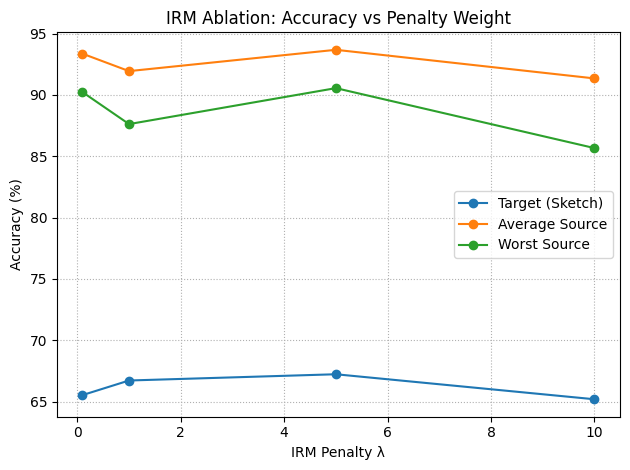

Saved: ./outputs_irm_ablation/figs/irm_acc_vs_lambda.png


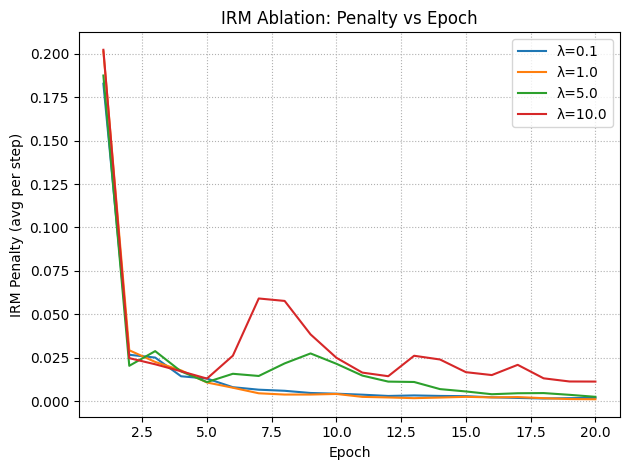

Saved: ./outputs_irm_ablation/figs/irm_penalty_vs_epoch.png


In [16]:
# @title Plots: (i) Accuracy vs λ, (ii) Penalty vs Epoch (no res_df dependency)
figdir = os.path.join(CFG["save_dir"], "figs")
os.makedirs(figdir, exist_ok=True)

if not results:
    raise RuntimeError("No results found. Run the IRM sweep cell first.")

# Order lambdas consistently (use the configured grid order)
lam_order = CFG["irm"]["lambda_grid"]
row_by_lam = {r["lambda"]: r for r in results if "lambda" in r}

# Build metric sequences in lam_order (skip lambdas that didn't finish)
x = [lam for lam in lam_order if lam in row_by_lam]
y_tgt   = [row_by_lam[lam]["target_acc"]      for lam in x]
y_avg   = [row_by_lam[lam]["avg_source_acc"]  for lam in x]
y_worst = [row_by_lam[lam]["worst_source_acc"] for lam in x]

plt.figure()
plt.plot(x, y_tgt,   marker="o", label="Target (Sketch)")
plt.plot(x, y_avg,   marker="o", label="Average Source")
plt.plot(x, y_worst, marker="o", label="Worst Source")
plt.xlabel("IRM Penalty λ")
plt.ylabel("Accuracy (%)")
plt.title("IRM Ablation: Accuracy vs Penalty Weight")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plot1 = os.path.join(figdir, "irm_acc_vs_lambda.png")
plt.savefig(plot1, bbox_inches="tight")
plt.show()
print("Saved:", plot1)

# Penalty vs epoch per-λ (pull from dfs dict)
plt.figure()
for lam in x:  # plot only the lambdas that completed
    df = dfs.get(lam, None)
    if df is None or "epoch" not in df or "irm_penalty" not in df:
        continue
    plt.plot(df["epoch"], df["irm_penalty"], label=f"λ={lam}")
plt.xlabel("Epoch")
plt.ylabel("IRM Penalty (avg per step)")
plt.title("IRM Ablation: Penalty vs Epoch")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plot2 = os.path.join(figdir, "irm_penalty_vs_epoch.png")
plt.savefig(plot2, bbox_inches="tight")
plt.show()
print("Saved:", plot2)


In [17]:
# @title Save per-λ logs
# Save logs
logdir = os.path.join(CFG["save_dir"], "logs")
os.makedirs(logdir, exist_ok=True)

for lam, df in dfs.items():
    out_path = os.path.join(logdir, f"irm_logs_lambda{lam}.csv")
    df.to_csv(out_path, index=False)
print("Saved per-lambda logs in", logdir)

if not results:
    raise RuntimeError("No results to summarize. Run the IRM sweep cell first.")

# Pick best by target accuracy (no DataFrame needed)
best_row = max(results, key=lambda r: r["target_acc"])
print("\nBest λ by target accuracy:")
for k, v in best_row.items():
    print(f"  {k}: {v}")

print("\nSuggested report sentences:")
print(f"- IRM penalty ablation across λ ∈ {CFG['irm']['lambda_grid']} shows best Target(Sketch) at λ={best_row['lambda']} "
      f"with Target {best_row['target_acc']:.2f}%, Avg Source {best_row['avg_source_acc']:.2f}%, Worst Source {best_row['worst_source_acc']:.2f}%.")
print("- The penalty-vs-epoch curves indicate whether the invariance constraint collapses to trivial solutions "
      "(near-zero penalty with low accuracy) or remains informative; pick the figure accordingly.")


Saved per-lambda logs in ./outputs_irm_ablation/logs

Best λ by target accuracy:
  lambda: 5.0
  target_acc: 67.23259762308999
  avg_source_acc: 93.67707960194387
  worst_source_acc: 90.55374592833876
  final_penalty: 0.0024192018900066614

Suggested report sentences:
- IRM penalty ablation across λ ∈ [0.1, 1.0, 5.0, 10.0] shows best Target(Sketch) at λ=5.0 with Target 67.23%, Avg Source 93.68%, Worst Source 90.55%.
- The penalty-vs-epoch curves indicate whether the invariance constraint collapses to trivial solutions (near-zero penalty with low accuracy) or remains informative; pick the figure accordingly.


In [18]:

# @title (Optional) Re-evaluate a saved model checkpoint by λ
def reload_model_and_eval(lambda_penalty: float):
    ckpt = os.path.join(CFG["save_dir"], "ckpts", f"irm_lambda{lambda_penalty}.pt")
    assert os.path.exists(ckpt), f"Missing checkpoint for λ={lambda_penalty}: {ckpt}"
    model = make_model(num_classes=7, pretrained=False, finetune_all=True)
    model.load_state_dict(torch.load(ckpt, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    per_src, avg_src, worst_src, tgt = eval_sources_target(model, source_val_loaders, target_eval_loader)
    print(pretty_metrics(per_src, avg_src, worst_src, tgt))
    return per_src, avg_src, worst_src, tgt

# Example:
# reload_model_and_eval(1.0)
